In [20]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import string
import os
import re
from tensorflow.keras.utils import text_dataset_from_directory
from tensorflow.keras.layers import TextVectorization, Embedding, Dropout, Dense, Dropout, Bidirectional, LSTM, Input, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint

In [23]:
# defining train and test dataset directories
train_dir = '/home/devcontainers/Datasets/train'
test_dir = '/home/devcontainers/Datasets/test'
os.listdir(train_dir)

['pos', 'neg']

In [47]:
batch_size = 64
seed = 42
maxLen = 200
vocab_size = 10000
embedding_dim = 50

In [48]:
train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.2, subset='training', seed=seed)
val_ds = text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.2, subset='validation', seed=seed)
test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [49]:
def standardize_texts(data):
    lowercase = tf.strings.lower(data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

vectorize_layer = TextVectorization(standardize=standardize_texts, max_tokens=vocab_size, output_mode='int', output_sequence_length=maxLen)

In [50]:
train_text = train_ds.map(lambda x, y : x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train = train_ds.map(vectorize_text)
val = val_ds.map(vectorize_text)
test = test_ds.map(vectorize_text)

In [52]:
print(vectorize_layer.get_vocabulary()[10])
print(vectorize_layer.get_vocabulary()[100])
print(vectorize_layer.get_vocabulary()[1000])
print(vectorize_layer.get_vocabulary()[9999])

i
characters
political
rushes


In [53]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

In [54]:
input = Input(shape=(maxLen,))
emb = Embedding(vocab_size, embedding_dim)(input)
x = SpatialDropout1D(0.2)(emb)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(input, output)

In [55]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 200, 50)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 200, 50)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        58,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 575,521 (2.20 MB)

 Trainable params: 575,521 (2.20 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(threshold=0.5)])
checkpoint = ModelCheckpoint('text_classifier_imdb.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
history = model.fit(train, batch_size=128, epochs=10, validation_data=val, callbacks=[checkpoint])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.5968 - loss: 0.6402
Epoch 1: val_loss improved from inf to 0.44040, saving model to text_classifier_imdb.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 1204s 4s/step - binary_accuracy: 0.5971 - loss: 0.6400 - val_binary_accuracy: 0.8098 - val_loss: 0.4404
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.8088 - loss: 0.4504
Epoch 2: val_loss improved from 0.44040 to 0.43254, saving model to text_classifier_imdb.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 1205s 4s/step - binary_accuracy: 0.8088 - loss: 0.4503 - val_binary_accuracy: 0.8080 - val_loss: 0.4325
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.8458 - loss: 0.3721
Epoch 3: val_loss improved from 0.43254 to 0.40886, saving model to text_classifier_imdb.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 1642s 5s/step - binary_accuracy: 0.8458 - loss: 0.3721 - val_binary_accuracy: 0.8126 - val_loss: 0.4089
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.8758 - loss: 0.3188
Epoch 4: val_loss improved from 0.40886 to 0.38817, saving model to text_classifier_imdb.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 1320s 4s/step - binary_accuracy: 0.8758 - loss: 0.3188 - val_binary_accuracy: 0.8348 - val_loss: 0.3882
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.8820 - loss: 0.2989
Epoch 5: val_loss did not improve from 0.38817
313/313 ━━━━━━━━━━━━━━━━━━━━ 1255s 4s/step - binary_accuracy: 0.8820 - loss: 0.2989 - val_binary_accuracy: 0.7046 - val_loss: 0.5529
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.8482 - loss: 0.3460
Epoch 6: val_loss did not improve from 0.38817
313/313 ━━━━━━━━━━━━━━━━━━━━ 1256s 4s/step - binary_accuracy: 0.8483 - loss: 0.3459 - val_binary_accuracy: 0.8296 - val_loss: 0.4048
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.9039 - loss: 0.2514
Epoch 7: val_loss did not improve from 0.38817
313/313 ━━━━━━━━━━━━━━━━━━━━ 1244s 4s/step - binary_accuracy: 0.9039 - loss: 0.2513 - val_binary_accuracy: 0.8200 - val_loss: 0.4303
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step 

In [57]:
loss, accuracy = model.evaluate(test)
print(loss)
print(accuracy)

391/391 ━━━━━━━━━━━━━━━━━━━━ 297s 758ms/step - binary_accuracy: 0.7940 - loss: 0.5465
0.5469828248023987
0.7956399917602539


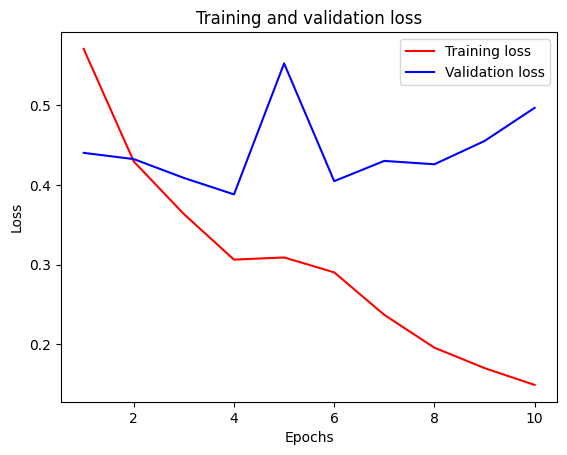

In [58]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

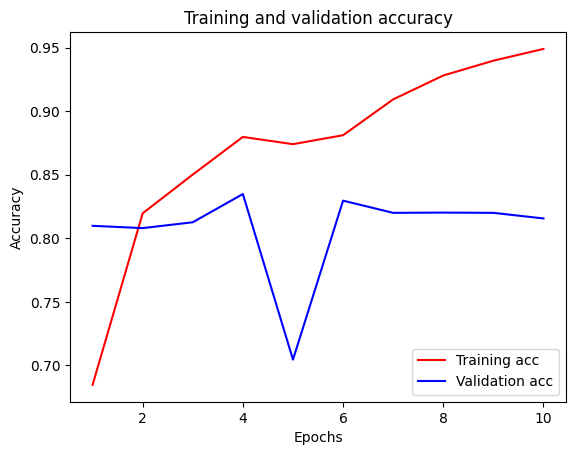

In [59]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()